# Exploration Notebook for local Force-Directed Layouts (Kamada-Kawai, UCI-ID 186, Image Segmentation)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import networkx as nx
import pandas as pd
import umap.plot
from ucimlrepo import fetch_ucirepo

d:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
d:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
d:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, erro

In [3]:
import sys

sys.path.append("../")
import visualization
import processing
import evaluation

## Data Preparation

In [4]:
# fetch dataset (available at https://archive.ics.uci.edu/dataset/186/wine+quality)
image_segmentation = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets, dtype="float32")

target_feature = "pH"
labels = pd.Categorical(y["quality"]).codes

X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


## Compute initial UMAP-Embedding

In [6]:
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=1, random_state=0)
umap_mapper.fit(X)
umap_embedding = umap_mapper.embedding_
connectivity_umap_knn = umap_mapper.graph_

d:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [7]:
pairwise_distances = processing.compute_pairwise_dists(
    X, invert=False, sim_features=[target_feature]
)

graph_umap_knn = nx.Graph(connectivity_umap_knn)
edge_weights_umap_knn = [
    graph_umap_knn[u][v]["weight"] for u, v in graph_umap_knn.edges()
]
connectivity_umap_knn_nx = nx.Graph(connectivity_umap_knn)

for u, v in connectivity_umap_knn_nx.edges():
    connectivity_umap_knn_nx[u][v]["weight"] = pairwise_distances[u][v]

## Compute Modifications

In [8]:
embeddings = processing.compute_multilevel_dr(
    graph=connectivity_umap_knn_nx,
    initial_pos=umap_embedding,
    pairwise_dists=pairwise_distances,
    mst=False,
    boundary_edges=False,
    threshold=None,
)

------------------------------------------------------------
Computing modified embedding via Kamada Kawai-layouting at level 1


d:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\networkx\drawing\layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


Computation finished after 11.41 seconds
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding via Kamada Kawai-layouting at level 2
Computation finished after 9.72 seconds
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding via Kamada Kawai-layouting at level 3
Computation finished after 12.96 seconds
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding via Kamada Kawai-layouting at level 4
Computation finished after 10.18 seconds
------------------------------------------------------------


In [9]:
for emb in embeddings:
    emb.labels = {i: X.at[i, target_feature] for i in range(len(labels))}

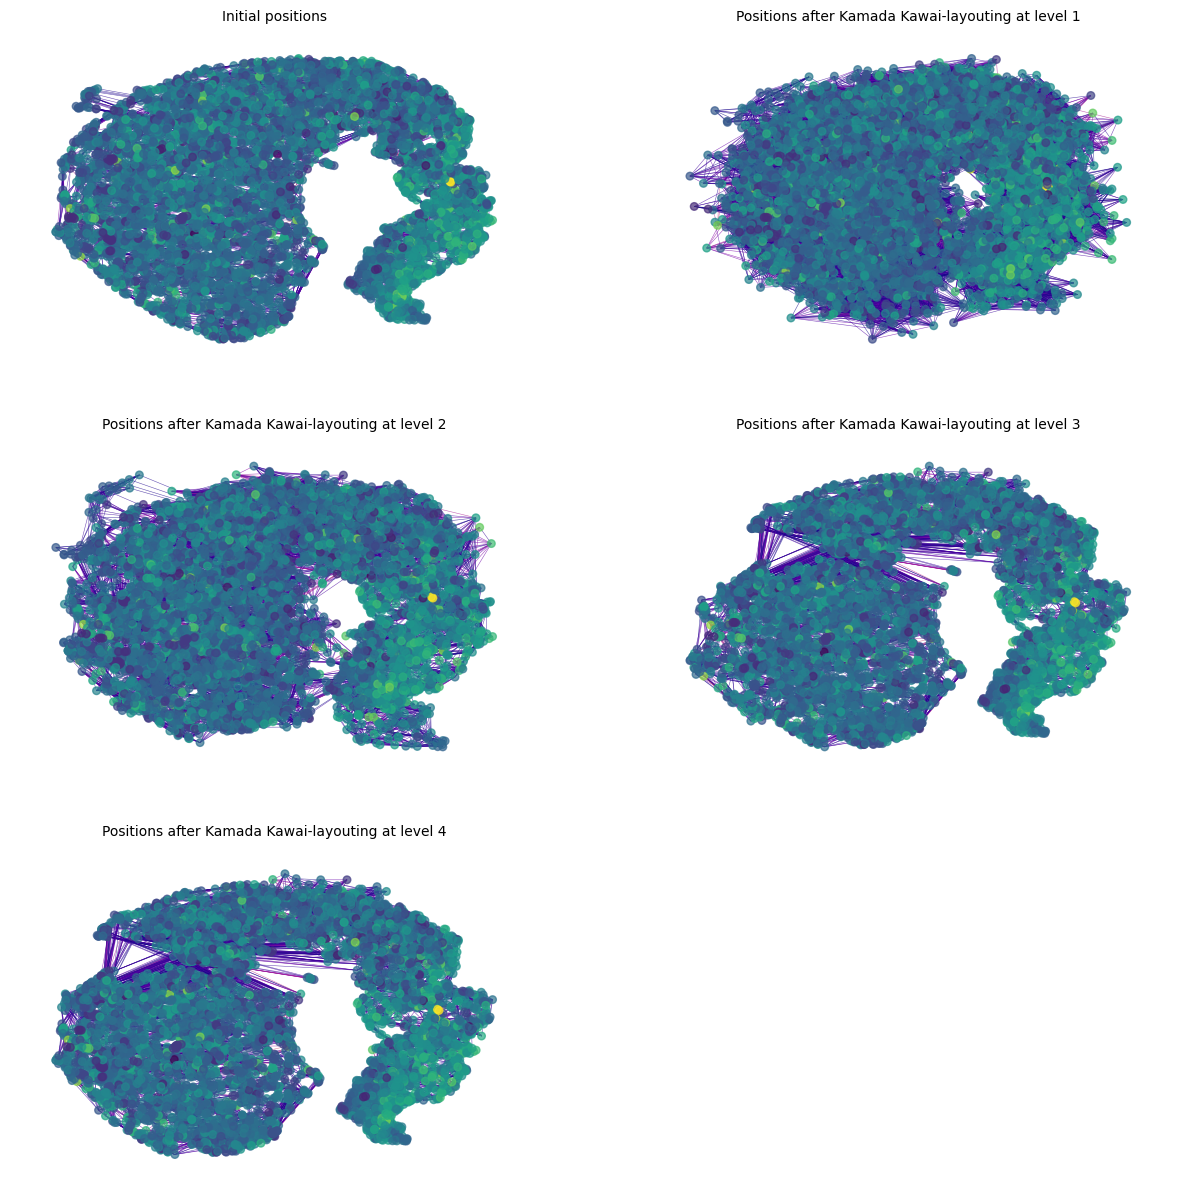

In [10]:
visualization.display_graphs(
    embeddings,
    figsize_columns=2,
    figsize=(15, 15),
    show_edges=True,
    cmap="viridis",
    show_cbar=False,
    show_partition_centers=False,
)

## Evaluation

In [11]:
embeddings = evaluation.compute_pairwise_metrics(X, embeddings)

------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  0
Computation finished after 1.34 seconds
------------------------------------------------------------
------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  1
Computation finished after 1.24 seconds
------------------------------------------------------------
------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  2
Computation finished after 1.46 seconds
------------------------------------------------------------
------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  3
Computation finished after 1.27 seconds
------------------------------------------------------------
------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  4
Comput

In [21]:
embeddings = evaluation.compute_global_metrics(X, embeddings, [target_feature])

------------------------------------------------------------
Computing global metrics for embedding with marker:  0.0
Computation finished after 37.56 seconds
------------------------------------------------------------
------------------------------------------------------------
Computing global metrics for embedding with marker:  1
Computation finished after 37.36 seconds
------------------------------------------------------------
------------------------------------------------------------
Computing global metrics for embedding with marker:  2
Computation finished after 45.24 seconds
------------------------------------------------------------
------------------------------------------------------------
Computing global metrics for embedding with marker:  3
Computation finished after 39.79 seconds
------------------------------------------------------------
------------------------------------------------------------
Computing global metrics for embedding with marker:  4
Computatio

In [ ]:
metrics_df = evaluation.metrics_report(embeddings)
metrics_df

,marker,m_total_score,metric_jaccard (size),m_q_local,m_trustworthiness,m_continuity,m_shepard_spearman,m_kruskal_stress,m_kruskal_stress_community
0,0.0,-0.028631,6497.0,0.731559,0.0,0.0,0.033156,1.907869,0.752726
1,1.0,-0.005273,6497.0,0.524153,0.0,0.0,0.030263,1.580783,0.738814
2,2.0,-0.002628,6497.0,0.601833,0.0,0.0,0.028671,1.643646,0.739830
3,3.0,-0.044739,6497.0,0.669485,0.0,0.0,0.033237,1.926418,0.738538
4,4.0,-0.043240,6497.0,0.670422,0.0,0.0,0.033252,1.919876,0.740385


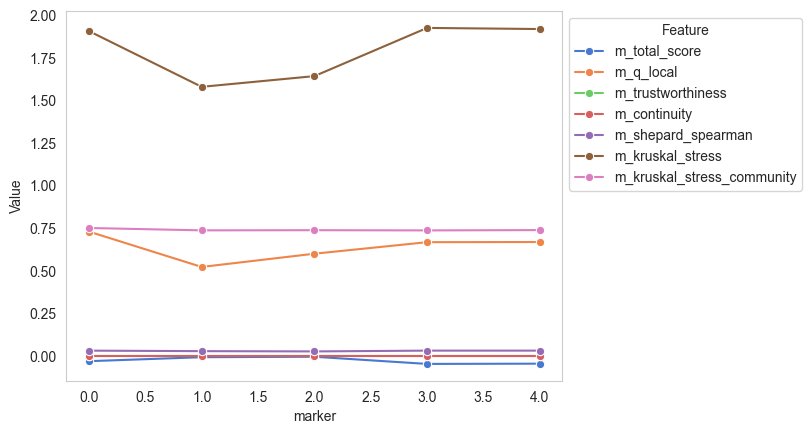

In [23]:
visualization.plot_metrics_report(metrics_df)

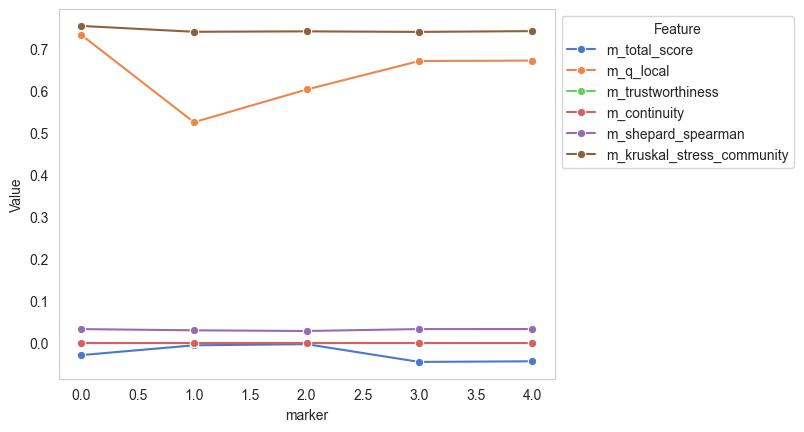

In [24]:
metrics_df = metrics_df.drop("m_kruskal_stress", axis=1)
visualization.plot_metrics_report(metrics_df)

## Interactive Visualization

In [16]:
import utils

utils.save_pickle(embeddings, filename="results_ml_dr_uci186")

In [17]:
import utils

embeddings = utils.load_pickle(filename="results_ml_dr_uci186_20250508-170711")

In [18]:
for emb in embeddings:
    emb.labels = {i: X.at[i, target_feature] for i in range(len(labels))}

In [19]:
from dash_overlay import DashOverlay

dash_app = DashOverlay(embeddings)

In [ ]:
dash_app.run()